# Set Up for Project Imports


In [1]:
import sys
from pathlib import Path
from data.api import UcIrvineAPI, UcIrvineDatasetIDs
import data.wrangling_utils
import duckdb
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    median_absolute_error,
)

In [2]:
source_directory = Path.cwd()
ROOT = source_directory.parent
data_directory  = ROOT / 'data'
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

In [3]:
# Auto-reload code changes
%load_ext autoreload
%autoreload 2

In [4]:
pandas.set_option('display.max_colwidth', None)  # show all text in cells
# pandas.set_option("display.max_rows", 100_000)
pandas.options.mode.copy_on_write = True
pandas.set_option('display.float_format', lambda x: '%.2f' % x)

# UcIrvine Data

In [5]:
uci = UcIrvineAPI.fetch_dataset(repo_id=UcIrvineDatasetIDs.Apartment_For_Rent_Classified.value)
uci_df: pandas.DataFrame = uci.data.original.reset_index()

/Users/isaacpacheco/Documents/School/Graduate/Fall 2025/CS 577 - Data Science/Project/Github/.venv/lib/python3.13/site-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (0,5,6,12,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


In [6]:
uci_df.describe()

,index,price,latitude,longitude,time
count,99826.00,99821.00,99797.00,99795.00,99820.00
mean,49912.50,1527.21,31476.04,-91.56,1559689694.18
std,28817.43,903.64,7022820.00,15.82,11044865.59
min,0.00,100.00,19.57,-159.37,1544174418.00
25%,24956.25,1014.00,33.75,-104.79,1550831772.75
50%,49912.50,1350.00,37.23,-84.56,1568745091.50
75%,74868.75,1795.00,39.95,-77.59,1568767125.25
max,99825.00,52500.00,1568782042.00,-68.78,1577391425.00


In [7]:
uci_df.shape

(99826, 23)

# Data Cleaning

In [8]:
clean_uci_df: pandas.DataFrame = data.wrangling_utils.clean(uci_df)

In [9]:
clean_uci_df: pandas.DataFrame = data.wrangling_utils.cast(clean_uci_df)
clean_uci_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99826 entries, 0 to 99825
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             99823 non-null  Int64  
 1   category       99825 non-null  string 
 2   title          99826 non-null  string 
 3   body           99826 non-null  string 
 4   amenities      83749 non-null  string 
 5   bathrooms      99757 non-null  Int64  
 6   bedrooms       99696 non-null  Int64  
 7   currency       99820 non-null  string 
 8   fee            99820 non-null  boolean
 9   has_photo      99820 non-null  boolean
 10  pets_allowed   39189 non-null  string 
 11  price          99821 non-null  Float64
 12  price_display  99819 non-null  Float64
 13  price_type     99820 non-null  string 
 14  square_feet    99821 non-null  Float64
 15  address        7920 non-null   string 
 16  cityname       99186 non-null  string 
 17  state          99425 non-null  string 
 18  latitu

In [10]:
clean_uci_df.rename(columns={'id':'uci_id'}, inplace=True)

In [11]:
if 'id' not in clean_uci_df.columns:
    clean_uci_df.insert(0, 'id', np.arange(len(clean_uci_df)))

# SQL

In [12]:
with duckdb.connect(database= (data_directory / 'apartments.duckdb')) as connection:
    _ = connection.execute(
    '''
        CREATE TABLE IF NOT EXISTS listings (
            id            BIGINT,
            uci_id        BIGINT,
            category      VARCHAR,
            title         VARCHAR,
            body          VARCHAR,
            amenities     VARCHAR,
            bathrooms     BIGINT,
            bedrooms      BIGINT,
            currency      VARCHAR,
            fee           BOOLEAN,
            has_photo     BOOLEAN,
            pets_allowed  VARCHAR,
            price         DOUBLE,
            price_display DOUBLE,
            price_type    VARCHAR,
            square_feet   DOUBLE,
            address       VARCHAR,
            cityname      VARCHAR,
            state         VARCHAR,
            latitude      DOUBLE,
            longitude     DOUBLE,
            source        VARCHAR,
            time          DOUBLE
        );
        '''
    )
    _ = connection.register("df_view", clean_uci_df)
    rows_before = connection.execute("SELECT COUNT(*) FROM listings").fetchone()[0]
    _ = connection.execute("INSERT INTO listings SELECT * FROM df_view WHERE id NOT IN (SELECT id FROM listings)")
    rows_after = connection.execute("SELECT COUNT(*) FROM listings").fetchone()[0]
    print(f'[Info] Inserted {rows_after - rows_before} records into listings.')


[Info] Inserted 0 records into listings.


# Exploratory Data Analysis


In [13]:
df = None
with duckdb.connect(database= (data_directory / 'apartments.duckdb')) as connection:
    df = connection.execute('''
    SELECT category,
    COUNT(*) AS count
    FROM listings
    WHERE
    category IS NOT NULL
    GROUP BY category
    ORDER BY category;
    ''').fetchdf()
df

,category,count
0,gym,1
1,"housing,rent",7
2,"housing,rent,apartment",99762
3,"housing,rent,commercial,retail",42
4,"housing,rent,condo",3
5,"housing,rent,home",4
6,"housing,rent,other",1
7,"housing,rent,short_term",4
8,"parking,patio,deck",1


In [14]:
with duckdb.connect(database= (data_directory / 'apartments.duckdb')) as connection:
    df = connection.execute('''
    SELECT price_type,
    COUNT(*) AS count
    FROM listings
    WHERE
    price_type IS NOT NULL
    GROUP BY price_type
    ORDER BY price_type;
    ''').fetchdf()
df

,price_type,count
0,monthly,99817
1,weekly,3


In [15]:
with duckdb.connect(database= (data_directory / 'apartments.duckdb')) as connection:
    df = connection.execute('''
    SELECT currency,
    COUNT(*) AS count
    FROM listings
    WHERE
    currency IS NOT NULL
    GROUP BY currency
    ORDER BY currency;
    ''').fetchdf()
df

,currency,count
0,USD,99820


#### Top 5 Listing Sources

In [16]:
with duckdb.connect(database= (data_directory / 'apartments.duckdb')) as connection:
    df = connection.execute('''
    SELECT source,
    COUNT(*) AS count
    FROM listings
    WHERE
    source IS NOT NULL
    GROUP BY source
    ORDER BY count DESC
    LIMIT 5;
    ''').fetchdf()
df

,source,count
0,rentdigs.com,91239
1,rentlingo,6924
2,listedbuy,571
3,gosection8,437
4,realrentals,269


#### Distribution of Count of Listings per State

In [17]:
with duckdb.connect(database= (data_directory / 'apartments.duckdb')) as connection:
    df = connection.execute('''
    SELECT *,
    FROM listings
    WHERE
    state IS NOT NULL
    ORDER BY state;
    ''').fetchdf()

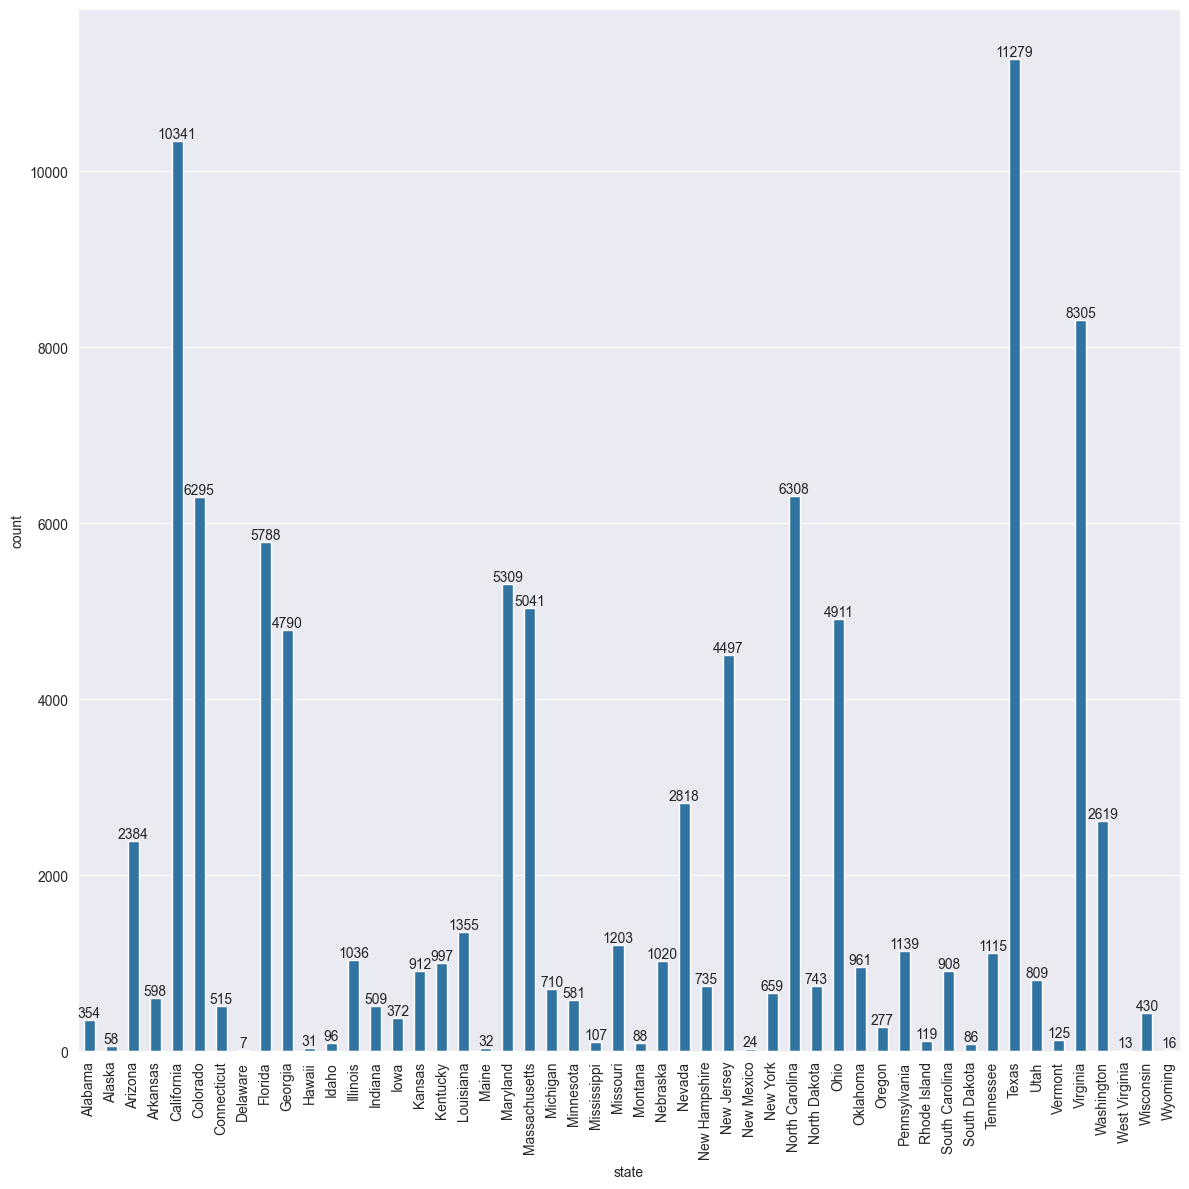

In [18]:
fig, axes = plt.subplots(1, 1, figsize=(12, 12))
ax = sns.countplot(data=df, x='state', width=0.5)

for container in ax.containers:
    ax.bar_label(container)

plt.xticks(rotation=90)
plt.tight_layout()

#### Descriptive Statistics of all listings

In [19]:
df.describe()

,id,uci_id,bathrooms,bedrooms,price,price_display,square_feet,latitude,longitude,time
count,99425.00,99425.00,99374.00,99303.00,99424.00,99424.00,99425.00,99425.00,99425.00,99425.00
mean,49946.73,5358279460.33,1.42,1.73,1525.11,1525.19,956.23,36.94,-91.56,1559663433.67
std,28799.96,184445642.47,0.53,0.75,902.86,902.90,387.30,4.61,15.84,11036115.34
min,0.00,5121046168.00,1.00,0.00,100.00,100.00,106.00,19.57,-159.37,1544174418.00
25%,25017.00,5197948914.00,1.00,1.00,1012.00,1012.75,730.00,33.74,-104.82,1550831650.00
50%,49878.00,5508672976.00,1.00,2.00,1350.00,1350.00,900.00,37.21,-84.55,1568745020.00
75%,74847.00,5509007225.00,2.00,2.00,1795.00,1795.00,1115.00,39.96,-77.61,1568767000.00
max,99825.00,5669438542.00,9.00,9.00,52500.00,52500.00,40000.00,64.83,-68.78,1577391425.00


An apartment with 9 bedrooms, a monthly cost of $120,000, and 50,000 square feet? Is this actually an apartment? Let's examine the listings by combinations of bedrooms and bathrooms, and distributions of prices and square footage.. It will give insight on the type of properties in our data.

## Removing Noise

In [20]:
with duckdb.connect(database= (data_directory / 'apartments.duckdb')) as connection:
    df = connection.execute('''
    SELECT bedrooms, bathrooms,
    COUNT(*) AS count
    FROM listings
    WHERE
    bedrooms IS NOT NULL AND bathrooms IS NOT NULL
    GROUP BY bedrooms, bathrooms
    ORDER BY bedrooms, bathrooms;
    ''').fetchdf()
df

,bedrooms,bathrooms,count
0,0,1,648
1,1,1,40196
2,1,2,248
3,2,1,16313
4,2,2,29717
5,2,3,89
6,3,1,2169
7,3,2,7847
8,3,3,549
9,3,4,18


It appears studios, townhomes, houses, mansions, or penthouses are also in the data. Some properties don't even have a bedroom? Other properties have 4+ bedrooms and bathrooms? That doesn't make sense for a typical apartment.

In [53]:
with duckdb.connect(database= (data_directory / 'apartments.duckdb')) as connection:
    df = connection.execute(f'''
    SELECT bedrooms, bathrooms, price
    FROM listings
    WHERE
    bedrooms IS NOT NULL AND bathrooms IS NOT NULL AND
    bedrooms >= 1 AND bedrooms <= 3 AND
    bathrooms >= 1 AND bathrooms <= 3;
    ''').fetchdf()
df.describe()

,bedrooms,bathrooms,price
count,97128.00,97128.00,97127.00
mean,1.69,1.40,1505.00
std,0.66,0.50,776.27
min,1.00,1.00,100.00
25%,1.00,1.00,1009.00
50%,2.00,1.00,1345.00
75%,2.00,2.00,1778.00
max,3.00,3.00,33165.00


Why is 3 bed and 3 bath priced at $33,0000? That seems overpriced even for a luxury apartment. Let's examine the distribution of listing prices for our data.

In [22]:
with duckdb.connect(database= (data_directory / 'apartments.duckdb')) as connection:
    df = connection.execute('''
    SELECT price,
    COUNT(*) AS count
    FROM listings
    WHERE
    bedrooms IS NOT NULL AND bathrooms IS NOT NULL AND
    price IS NOT NULL AND
    bedrooms >= 1 AND bedrooms <= 3 AND
    bathrooms >= 1 AND bathrooms <= 3
    GROUP BY price;
    ''').fetchdf()

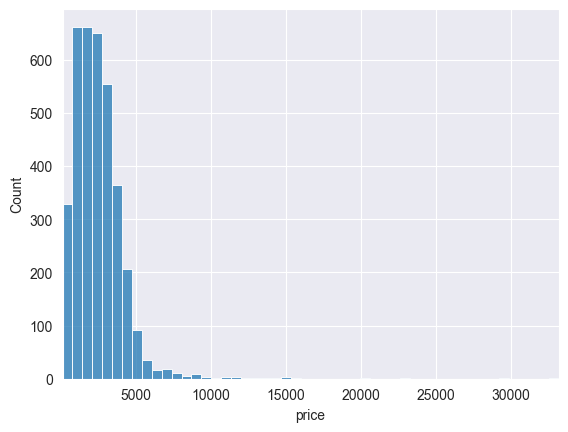

In [23]:
sns.histplot(df['price'], bins=50)
plt.xlim(df['price'].min(), df['price'].max())
plt.show()

The distribution of prices is unimodal, and it is strongly right skewed where most the data is centered around 2,000-3,0000 USD. There are extreme outliers of 10,000-30,000. Maybe luxurious apartments/penthouse are causing this.

In [54]:
with duckdb.connect(database= (data_directory / 'apartments.duckdb')) as connection:
    df = connection.execute('''
    SELECT bedrooms, bathrooms, price
    FROM listings
    WHERE
    bedrooms IS NOT NULL AND bathrooms IS NOT NULL AND
    price IS NOT NULL AND
    bedrooms >= 1 AND bedrooms <= 3 AND
    bathrooms >= 1 AND bathrooms <= 3 AND
    price >= 500 AND price <= 10000;
    ''').fetchdf()
df.describe()

,bedrooms,bathrooms,price
count,96636.00,96636.00,96636.00
mean,1.69,1.40,1505.41
std,0.66,0.50,730.35
min,1.00,1.00,500.00
25%,1.00,1.00,1015.00
50%,2.00,1.00,1350.00
75%,2.00,2.00,1780.00
max,3.00,3.00,10000.00


Now let's examine the distribution of prices again.

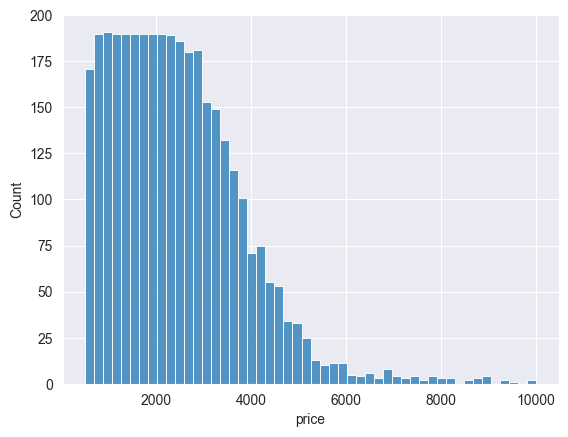

In [56]:
with duckdb.connect(database= (data_directory / 'apartments.duckdb')) as connection:
    df = connection.execute('''
    SELECT price,
    COUNT(*) AS count
    FROM listings
    WHERE
    bedrooms IS NOT NULL AND bathrooms IS NOT NULL AND
    price IS NOT NULL AND
    bedrooms >= 1 AND bedrooms <= 3 AND
    bathrooms >= 1 AND bathrooms <= 3 AND
    price >= 500 AND price <= 10000
    GROUP BY price;
    ''').fetchdf()
sns.histplot(df['price'], bins=50)
plt.show()

The distribution of the listing prices is still right skewed but we got rid of some noise. Now let's examine the distribution of the square footage of the listings since ~5,000 square foot apartment still seems large for a max 3 bedroom and 3 bathroom apartment.

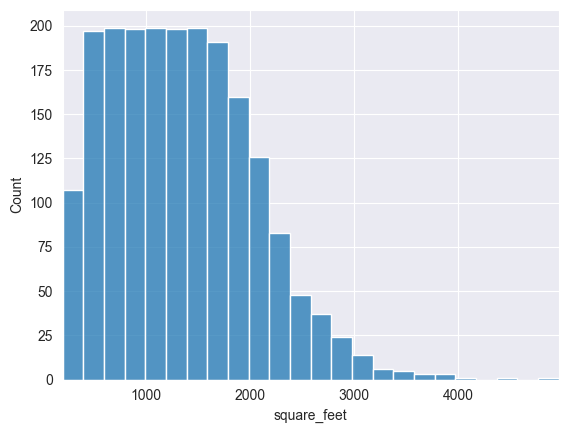

In [57]:
with duckdb.connect(database= (data_directory / 'apartments.duckdb')) as connection:
    df = connection.execute('''
    SELECT square_feet,
    COUNT(*) AS count
    FROM listings
    WHERE
    bedrooms IS NOT NULL AND bathrooms IS NOT NULL AND
    price IS NOT NULL AND square_feet IS NOT NULL AND
    bedrooms >= 1 AND bedrooms <= 3 AND
    bathrooms >= 1 AND bathrooms <= 3 AND
    price >= 500 AND price <= 10000
    GROUP BY square_feet
    ''').fetchdf()
sns.histplot(df['square_feet'], bins=24)
plt.xlim(df['square_feet'].min(), df['square_feet'].max())
plt.show()

In [62]:
with duckdb.connect(database= (data_directory / 'apartments.duckdb')) as connection:
    df = connection.execute('''
    SELECT bathrooms, bedrooms, price, square_feet
    FROM listings
    WHERE
    bedrooms IS NOT NULL AND bathrooms IS NOT NULL AND
    price IS NOT NULL AND square_feet IS NOT NULL AND
    bedrooms >= 1 AND bedrooms <= 3 AND
    bathrooms >= 1 AND bathrooms <= 3 AND
    price >= 500 AND price <= 10000 AND
    square_feet <= 4000;
    ''').fetchdf()
df.describe()

,bathrooms,bedrooms,price,square_feet
count,96633.00,96633.00,96633.00,96633.00
mean,1.40,1.69,1505.29,935.86
std,0.50,0.66,729.81,289.97
min,1.00,1.00,500.00,200.00
25%,1.00,1.00,1015.00,730.00
50%,1.00,2.00,1350.00,900.00
75%,2.00,2.00,1780.00,1104.00
max,3.00,3.00,10000.00,3906.00


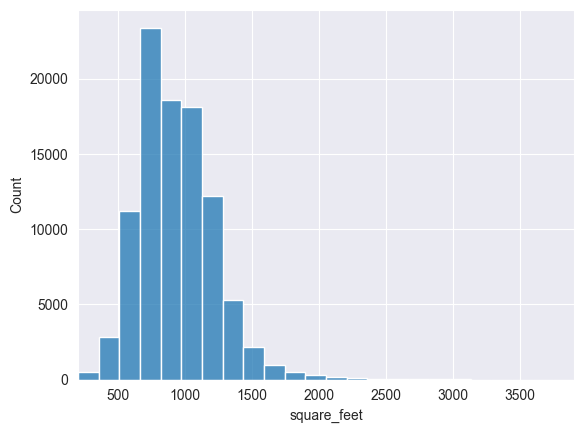

In [28]:
sns.histplot(df['square_feet'], bins=24)
plt.xlim(df['square_feet'].min(), df['square_feet'].max())
plt.show()

In [66]:
with duckdb.connect(database= (data_directory / 'apartments.duckdb')) as connection:
    df = connection.execute('''
    SELECT bathrooms, bedrooms, price, square_feet, state, latitude, longitude, cityname
    FROM listings
    WHERE
    bedrooms IS NOT NULL AND bathrooms IS NOT NULL AND
    price IS NOT NULL AND square_feet IS NOT NULL AND
    price_type IS NOT NULL AND state IS NOT NULL AND
    latitude IS NOT NULL AND longitude IS NOT NULL AND
    cityname IS NOT NULL AND category is NOT NULL AND
    bedrooms >= 1 AND bedrooms <= 3 AND
    bathrooms >= 1 AND bathrooms <= 3 AND
    price >= 500 AND price <= 10000 AND
    square_feet <= 4000 AND
    price_type = 'monthly' AND
    category LIKE '%apartment%';
    ''').fetchdf()

In [67]:
df.describe()

,bathrooms,bedrooms,price,square_feet,latitude,longitude
count,96009.00,96009.00,96009.00,96009.00,96009.00,96009.00
mean,1.40,1.69,1500.08,936.04,36.92,-91.53
std,0.50,0.66,721.65,289.53,4.60,15.79
min,1.00,1.00,500.00,200.00,19.67,-159.37
25%,1.00,1.00,1014.00,731.00,33.73,-104.81
50%,1.00,2.00,1347.00,900.00,37.18,-84.54
75%,2.00,2.00,1775.00,1104.00,39.94,-77.58
max,3.00,3.00,10000.00,3906.00,64.83,-68.78


In [68]:
df.shape

(96009, 8)

In [69]:
percent_change = (1.0 - (df.shape[0] / uci_df.shape[0])) * 100
print(f"Percent change {percent_change:.3f}%")

Percent change 3.824%


## More Skewness Analysis

In [70]:
df[['price', 'square_feet']].skew()

price         2.28
square_feet   1.17
dtype: float64

| Feature       | Skew     | Interpretation            | Action               |
| ------------- |----------|---------------------------|----------------------|
| `price`       | **2.28** | **Strongly right-skewed** | Should transform     |
| `square_feet` | **1.17** | **Strongly right-skewed** | Should transform     |


Most the data is small to large apartments prices around $1,500 - 3,000 but a handful of extremely underpriced/overpriced apartments are skewing the data. So we will perform a log transformation to reduce their influence.

In [34]:
df['price_log'] = np.log1p(df['price'])
df['square_feet_log'] = np.log1p(df['square_feet'])
df[['price_log', 'square_feet_log']].skew()

price_log          0.36
square_feet_log   -0.21
dtype: float64

| Feature       | Skew              | Interpretation         |
|---------------|-------------------|-------------------------|
| `price`       | **2.28 -> 0.36**  | **Weakly right-skewed** |
| `square_feet` | **1.17 -> -0.21** | **Weakly left-skewed**  |

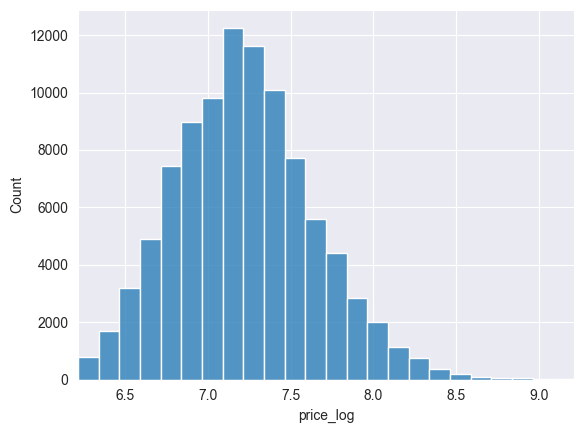

In [35]:
sns.histplot(df['price_log'], bins=24)
plt.xlim(df['price_log'].min(), df['price_log'].max())
plt.show()

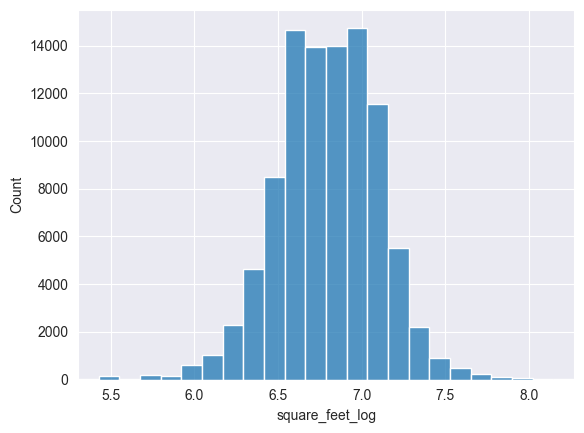

In [36]:
sns.histplot(df['square_feet_log'], bins=24)
plt.xlim(df['square_feet_log'].min(), df['square_feet_log'].max())
plt.show()

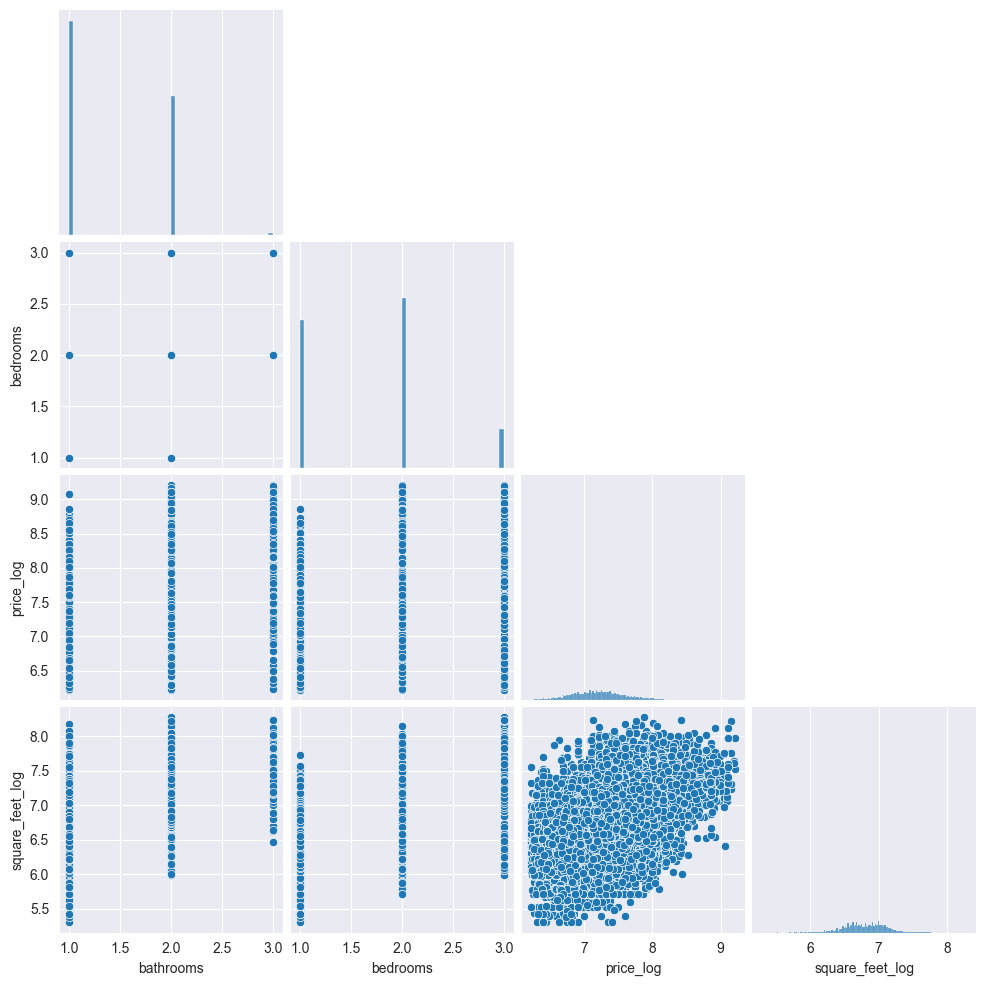

In [37]:
grid = sns.pairplot(df[['bathrooms', 'bedrooms', 'price_log', 'square_feet_log']], kind='scatter', corner=True)

There only seems a weak linear relationship between log_price and square_feet_log.

In [38]:
correlation = df[['bathrooms', 'bedrooms', 'price_log', 'square_feet_log']].corr(numeric_only=True)

In [39]:
correlation

,bathrooms,bedrooms,price_log,square_feet_log
bathrooms,1.00,0.65,0.31,0.68
bedrooms,0.65,1.00,0.21,0.66
price_log,0.31,0.21,1.00,0.36
square_feet_log,0.68,0.66,0.36,1.00


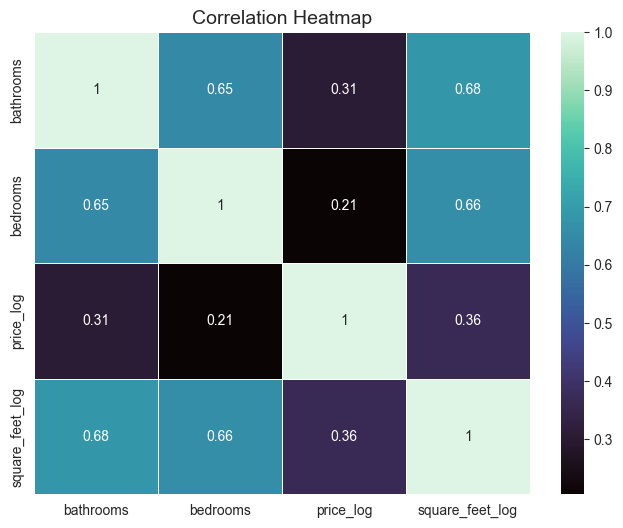

In [40]:
plt.figure(figsize=(8, 6))
plt.title("Correlation Heatmap", fontsize=14)
sns.heatmap(correlation, annot=True, linewidths=0.5, cmap='mako')
plt.show()

### Variable Types

- Discrete / ordinal: bedrooms, bathrooms — integer counts
- Continuous: price_log, square_feet_log — continuous and normalized
- We used Pearson correlation, the relationships involving discrete counts are approximate linear associations, not strict parametric correlations — but they’re still informative here since the discrete values are ordered and range reasonably (0–9).


| Pair                            | Correlation | Interpretation                                                                                                                                            |
| ------------------------------- |-------------| --------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **bathrooms ↔ bedrooms**        | **0.65**    | Strong positive relationship — homes with more bedrooms usually have more bathrooms.                                                                      |
| **bathrooms ↔ square_feet_log** | **0.68**    | Strong positive correlation — larger houses naturally have more bathrooms.                                                                                |
| **bedrooms ↔ square_feet_log**  | **0.66**    | Same strong pattern — larger homes have more bedrooms.                                                                                                    |
| **price_log ↔ square_feet_log** | **0.36**    | Moderate positive relationship — price generally rises with size, but not perfectly (other factors matter).                                               |
| **price_log ↔ bathrooms**       | **0.31**    | Mild correlation — price increases somewhat with bathroom count, but not linearly.                                                                        |
| **price_log ↔ bedrooms**        | **0.21**    | Weak correlation — price doesn’t increase as predictably with bedroom count, possibly because extra bedrooms add less marginal value than square footage. |


## Skewnesss by State

In [41]:
state_groups = df.groupby("state")
for state, group in state_groups:
    numeric_df = group[["bathrooms", "bedrooms", "price_log", "square_feet_log"]]
    skew_per_state = numeric_df.skew()
    print(f"{state}\n{skew_per_state}\n")

Alabama
bathrooms          0.29
bedrooms           0.18
price_log          1.03
square_feet_log   -0.40
dtype: float64

Alaska
bathrooms         2.10
bedrooms          0.47
price_log         0.79
square_feet_log   0.18
dtype: float64

Arizona
bathrooms          0.19
bedrooms           0.39
price_log         -0.12
square_feet_log   -0.49
dtype: float64

Arkansas
bathrooms         -0.06
bedrooms           0.27
price_log          0.55
square_feet_log   -0.08
dtype: float64

California
bathrooms          0.68
bedrooms           0.44
price_log          0.16
square_feet_log   -0.11
dtype: float64

Colorado
bathrooms          0.63
bedrooms           0.51
price_log          0.05
square_feet_log   -0.44
dtype: float64

Connecticut
bathrooms          1.64
bedrooms           0.19
price_log          0.41
square_feet_log   -0.37
dtype: float64

Delaware
bathrooms          2.45
bedrooms           1.54
price_log          2.33
square_feet_log   -0.89
dtype: float64

Florida
bathrooms         -0.03
bed

## Correlation by State

In [42]:
correlation_by_state = {}
for state, group in state_groups:
    numeric_df = group[["bathrooms", "bedrooms", "price_log", "square_feet_log"]]
    correlation_by_state[state] = numeric_df.corr()

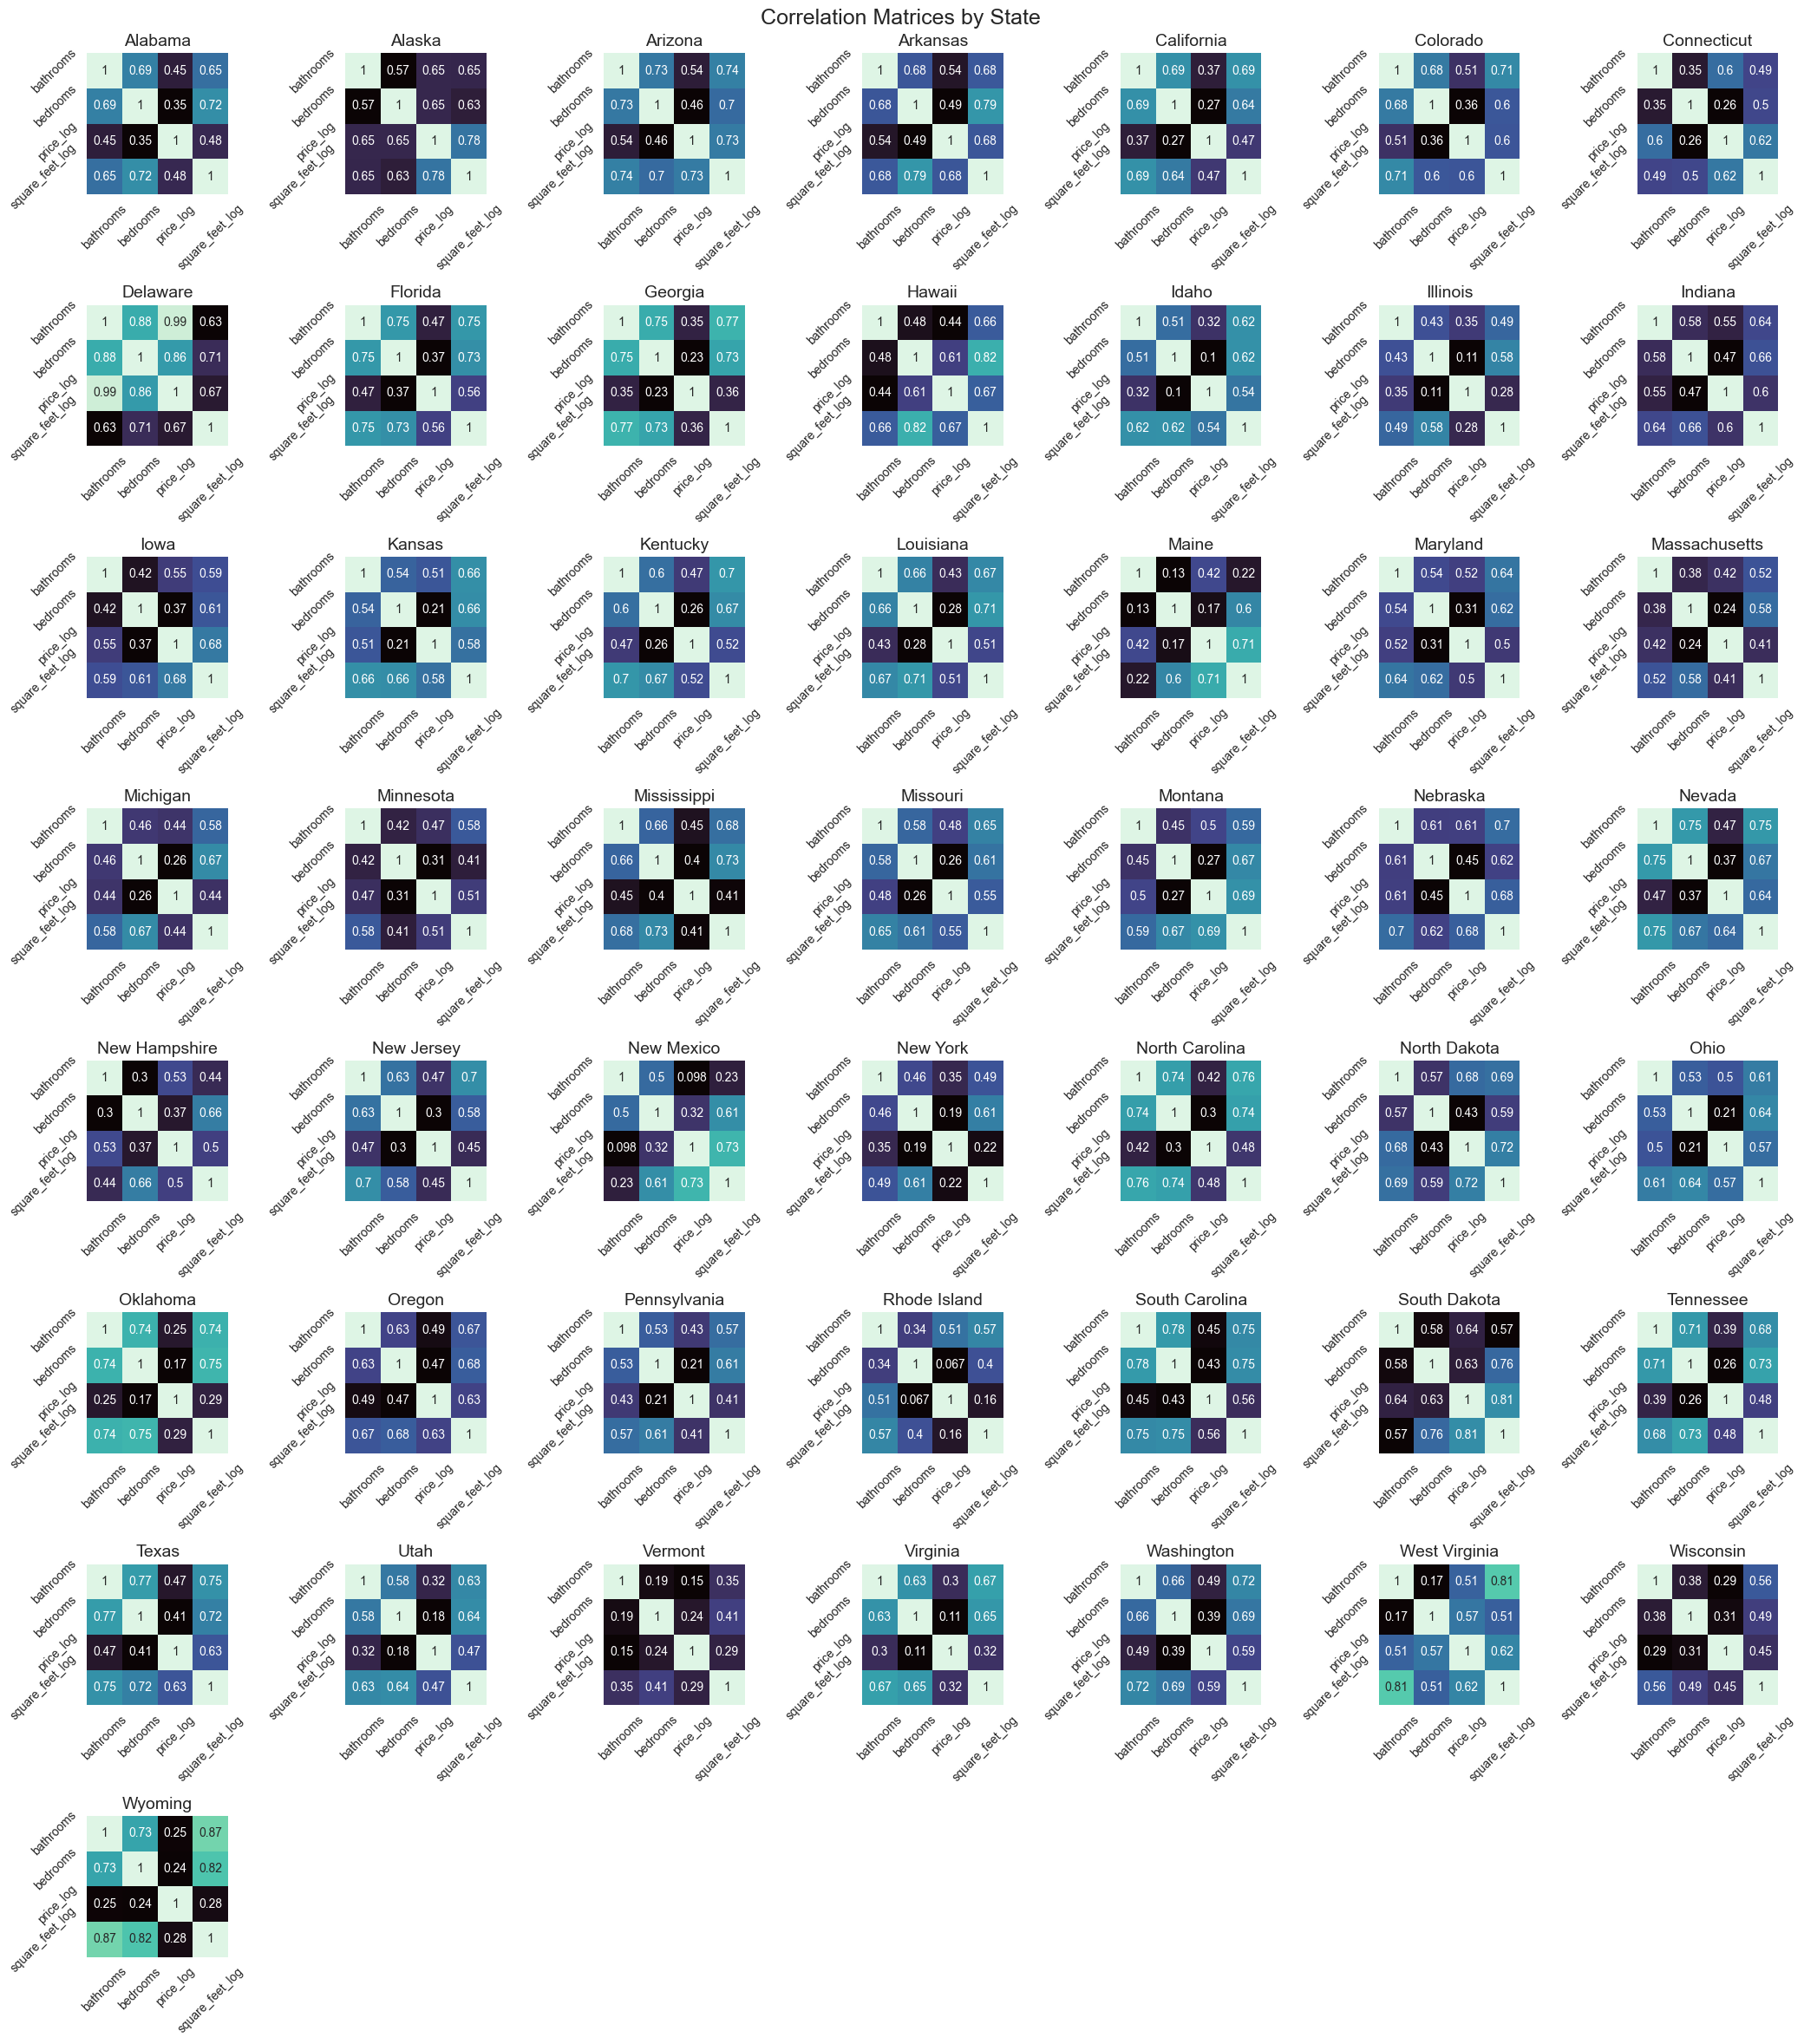

In [43]:
n_states = len(correlation_by_state.keys())
# Grid size (fits 51)
rows = 8
cols = 7
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
axes = axes.flatten()
for idx, state in enumerate(correlation_by_state.keys()):
    ax = axes[idx]
    corr = correlation_by_state[state]

    sns.heatmap(
        corr,
        ax=ax,
        cmap="mako",
        square=True,
        xticklabels=True,
        yticklabels=True,
        annot=True,
        cbar=False
    )

    ax.set_title(state, fontsize=14)
    ax.tick_params(axis='x', labelrotation=45, labelsize=10)
    ax.tick_params(axis='y', labelrotation=45, labelsize=10)

# Hide any unused subplot cells
for j in range(len(correlation_by_state.keys()), len(axes)):
    axes[j].axis("off")

fig.suptitle("Correlation Matrices by State", fontsize=18)
plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.99))
plt.show()

# K Means Clustering

In [44]:
clusterer = KMeans(n_clusters=30, random_state=42)
df['geo_cluster'] = clusterer.fit_predict(df[['latitude', 'longitude']])

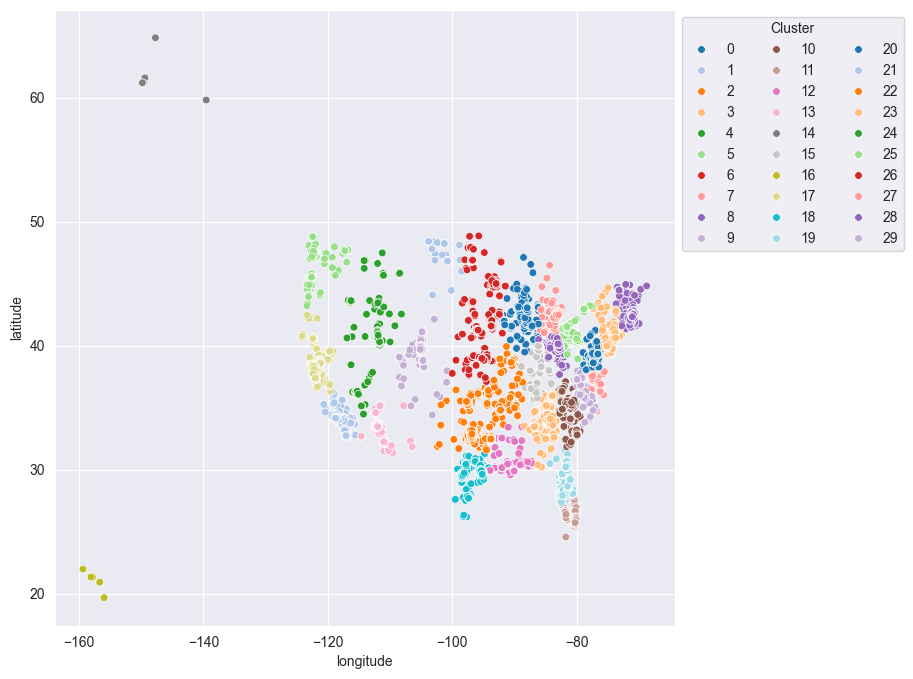

In [45]:
plt.figure(figsize=(8, 8))

ax = sns.scatterplot(
    data=df,
    x="longitude",
    y="latitude",
    hue="geo_cluster",
    palette="tab20",
    s=30
)

handles, labels = ax.get_legend_handles_labels()
plt.legend(
    handles=handles,
    labels=labels,
    title="Cluster",
    ncol=3,
    bbox_to_anchor=(1,1),
    loc="upper left"
)

plt.show()

In [46]:
X = df[['square_feet_log', 'bedrooms', 'bathrooms', 'state', 'geo_cluster', 'cityname']]
y = df['price_log']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

preprocessor = ColumnTransformer([
    ("square_feet_log_poly", PolynomialFeatures(degree=2, include_bias=False), ['square_feet_log']),
    ('structura_linear', 'passthrough', ['bedrooms', 'bathrooms']),
    ('city_encoded', OneHotEncoder(handle_unknown='ignore'), ['cityname']),
    ('neighborhood_cluster_encoded', OneHotEncoder(handle_unknown='ignore'), ['geo_cluster'])
])

model = Pipeline([
    ('preprocess', preprocessor),
    ('linreg', LinearRegression()),
])


model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# ==========================
# 7. Metrics helper (includes Adjusted R²)
# ==========================
def adjusted_r2(y_true, y_pred, n_features: int) -> float:
    """Compute Adjusted R² given predictions and number of original features."""
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    p = n_features
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)


def print_regression_metrics(split_name, y_true, y_pred, n_features: int):
    r2 = r2_score(y_true, y_pred)
    adj_r2 = adjusted_r2(y_true, y_pred, n_features)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    med_ae = median_absolute_error(y_true, y_pred)

    print(f"=== {split_name} Metrics ===")
    print(f"R²:              {r2:.2f}")
    print(f"Adjusted R²:     {adj_r2:.2f}")
    print(f"MSE:             {mse:.2f}")
    print(f"RMSE:            {rmse:.2f}")
    print(f"MAE:             {mae:.2f}")
    print(f"MAPE:            {mape:.2f}")
    print(f"Median Abs Err:  {med_ae:.2f}")
    print()


# ==========================
# 8. Interpret real-world error from log-space metrics
# ==========================
def interpret_log_error_metrics(split_name, y_true, y_pred):
    """
    Interpret log-space error metrics in real price terms.
    Assumes y_true and y_pred are log(price).
    """
    rmse_log = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_log = mean_absolute_error(y_true, y_pred)
    med_ae_log = median_absolute_error(y_true, y_pred)

    # Convert log errors to multiplicative factors
    rmse_factor = np.exp(rmse_log)
    mae_factor = np.exp(mae_log)
    med_factor = np.exp(med_ae_log)

    rmse_pct = (rmse_factor - 1.0) * 100.0
    mae_pct = (mae_factor - 1.0) * 100.0
    med_pct = (med_factor - 1.0) * 100.0

    print(f"=== {split_name} Real-World Error Interpretation ===")
    print(f"Typical error (RMSE):    x {rmse_factor:.3f}  (predictions are typically off by ~{rmse_pct:.1f}% in true price)")
    print(f"Average error (MAE):     x {mae_factor:.3f}  (On average, predictions are off by ~{mae_pct:.1f}% in true price)")
    print(f"Typical core error (Median AE): x {med_factor:.3f}  (For half the homes, predictions are off within ~{med_pct:.1f}% in true price)")
    print()


# number of ORIGINAL features (bathrooms, bedrooms, sqft_log, state)
n_features = model.named_steps["preprocess"].transform(X_train).shape[1]

print_regression_metrics("Train", y_train, y_train_pred, n_features)
print_regression_metrics("Test",  y_test,  y_test_pred,  n_features)

interpret_log_error_metrics("Train", y_train, y_train_pred)
interpret_log_error_metrics("Test",  y_test,  y_test_pred)


=== Train Metrics ===
R²:              0.78
Adjusted R²:     0.77
MSE:             0.04
RMSE:            0.20
MAE:             0.15
MAPE:            0.02
Median Abs Err:  0.11

=== Test Metrics ===
R²:              0.76
Adjusted R²:     0.72
MSE:             0.04
RMSE:            0.20
MAE:             0.15
MAPE:            0.02
Median Abs Err:  0.12

=== Train Real-World Error Interpretation ===
Typical error (RMSE):    x 1.218  (predictions are typically off by ~21.8% in true price)
Average error (MAE):     x 1.157  (On average, predictions are off by ~15.7% in true price)
Typical core error (Median AE): x 1.116  (For half the homes, predictions are off within ~11.6% in true price)

=== Test Real-World Error Interpretation ===
Typical error (RMSE):    x 1.225  (predictions are typically off by ~22.5% in true price)
Average error (MAE):     x 1.164  (On average, predictions are off by ~16.4% in true price)
Typical core error (Median AE): x 1.122  (For half the homes, predictions are of

| Metric               | Train Value | Test Value | Interpretation                                                                                                                   |
|----------------------|-------------|------------|----------------------------------------------------------------------------------------------------------------------------------|
| **R²**               | 0.78        | 0.76       | % of variance explained. Model captures ~78% of training variation and ~76% of unseen variation **strong fit, low overfitting**. |
| **MSE**              | 0.04        | 0.04       | Average squared error. Test MSE only slightly higher **good generalization**.                                                    |
| **RMSE**             | 0.20        | 0.21       | Typical prediction error magnitude, ~20–21% deviation in normalized/log scale.                                                   |
| **MAE**              | 0.15        | 0.15       | Average absolute error, predictions off by ~15%.                                                                                 |
| **MAPE**             | 0.02        | 0.02       | Mean Absolute Percentage Error ~2% if target is scaled, or ~2% error in/log space. Very low **consistent accuracy**.             |
| **Median Abs Error** | 0.11        | 0.11       | Half of predictions are within **11% error**. Indicates tight, stable core accuracy.                                             |


In [47]:
train_resid = y_train - y_train_pred
test_resid  = y_test  - y_test_pred

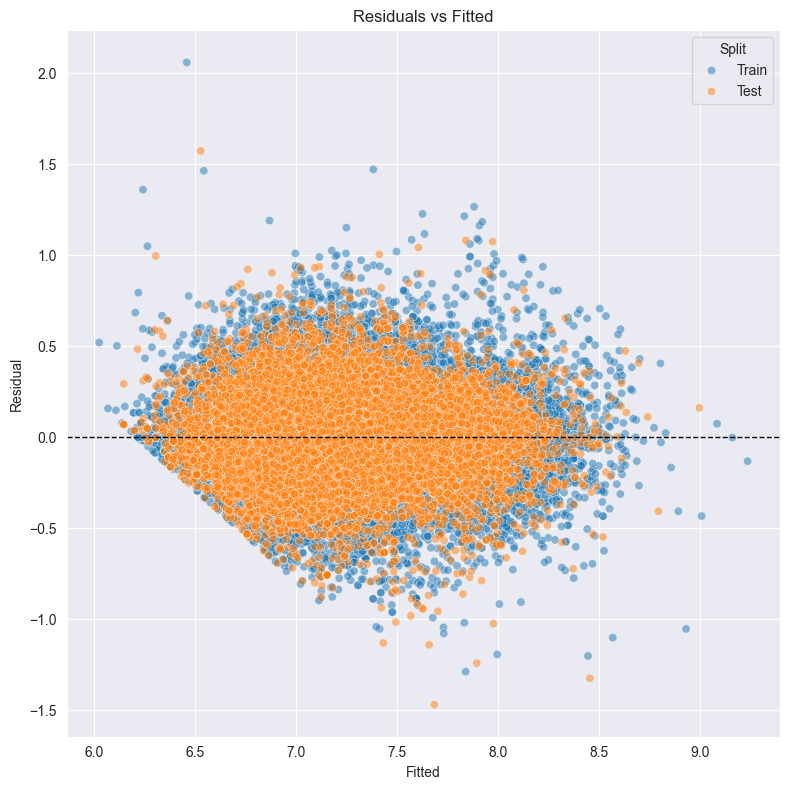

In [48]:
# Build DataFrames for easy plotting
train_df = pandas.DataFrame({
    "Fitted": y_train_pred,
    "Residual": train_resid,
    "Split": "Train"
})

test_df = pandas.DataFrame({
    "Fitted": y_test_pred,
    "Residual": test_resid,
    "Split": "Test"
})

resid_df = pandas.concat([train_df, test_df], ignore_index=True)

# Plot
plt.figure(figsize=(8, 8))
sns.scatterplot(
    data=resid_df,
    x="Fitted",
    y="Residual",
    hue="Split",
    alpha=0.5
)

plt.axhline(0, linestyle="--", color="black", linewidth=1)
plt.title("Residuals vs Fitted")
plt.xlabel("Fitted")
plt.ylabel("Residual")
plt.tight_layout()
plt.show()

In [49]:
# DO NOT DELETE MIGHT NEED
# import json
# s = cleaned_uci_df['bathrooms'].explode()
# global_counts = s.value_counts().to_dict()
# global_counts
# print(f'BAD_DATA: {json.dumps(BAD_DATA['cityname'], indent=2)}')  # CHANGE COL
# uci_df["state_full"] = uci_df["state"].str.upper().map(STATE_MAP)
# print(uci_df.shape)
# uci_df.dropna(subset=["state_full"], inplace=True)
# uci_df.shape

# Simple Linear Regression

In [50]:
lin_regression_residuals = {}
for state, group in state_groups:
    # choose numeric columns only
    X = group[["bathrooms", "bedrooms", "square_feet_log"]]
    y = group[['price_log']]
    model = LinearRegression()
    model.fit(X, y)
    # Predictions and residuals
    y_pred = model.predict(X)
    residuals = y - y_pred
    lin_regression_residuals[state] = y_pred, residuals

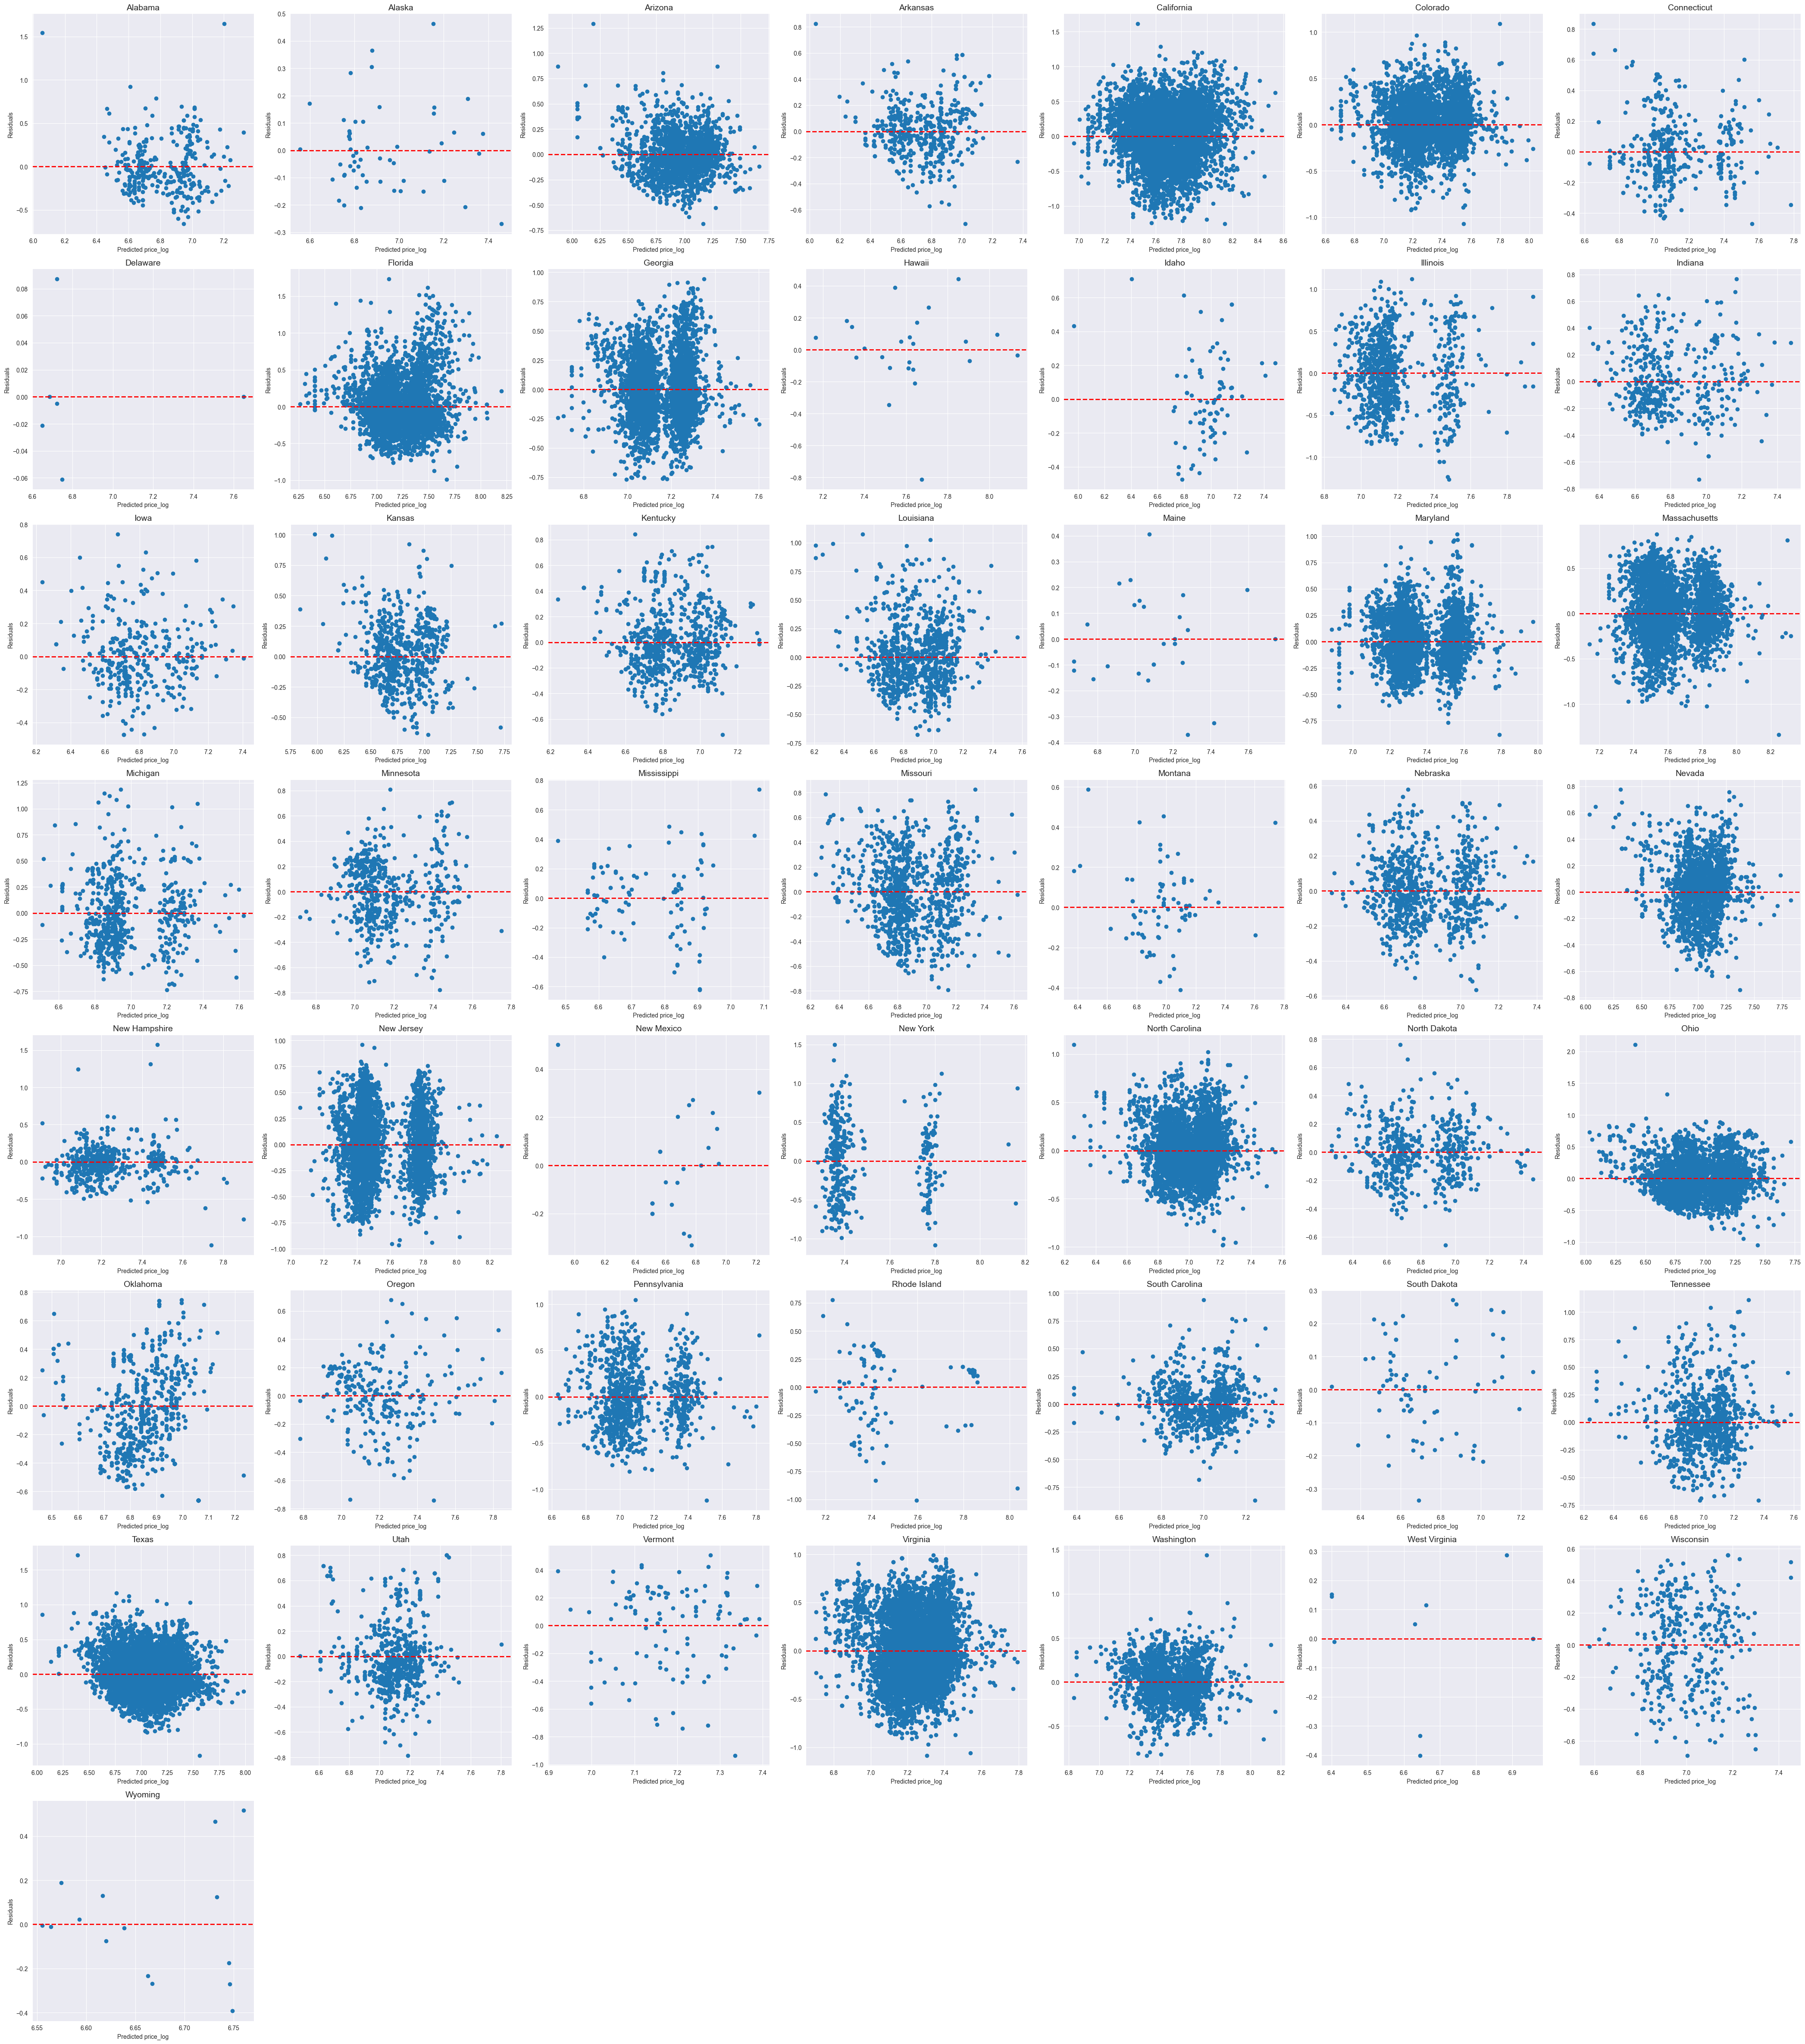

In [51]:
# Grid size (fits 51)
rows = 8
cols = 7
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6))
axes = axes.flatten()
for idx, state in enumerate(lin_regression_residuals.keys()):
    ax = axes[idx]
    y_pred, residuals = lin_regression_residuals[state]
    ax.scatter(y_pred, residuals)
    ax.axhline(0, color='red', linestyle='--', linewidth=2)
    ax.set_title(state, fontsize=14)
    ax.set_xlabel('Predicted price_log', fontsize=10)
    ax.set_ylabel('Residuals', fontsize=10)
    ax.set_title(state, fontsize=14)
# Hide any unused subplot cells
for j in range(len(lin_regression_residuals.keys()), len(axes)):
    axes[j].axis("off")
plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.99))
plt.show()